In [89]:
# Import needed packages

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [90]:
# Download historical data

# Inputs
tickers = ["AAPL", "MSFT", "JNJ", "XOM", "JPM", "TSLA"]
start_date = "2018-01-01"
end_date = "2024-12-31" # Use None for today

# Download and select closing prices
data = yf.download(tickers, start = start_date, end = end_date, actions = True)["Close"] # actions=True Ensures that dividends and stock splits are accounted for

# Drops any rows with missing data
data.dropna(inplace=True)

# Calculate returns
returns = data.pct_change().dropna()

# Check data
print(data.head())
print(returns.head())

[*********************100%***********************]  6 of 6 completed

Ticker           AAPL         JNJ        JPM       MSFT       TSLA        XOM
Date                                                                         
2018-01-02  40.479847  113.850296  87.571884  79.474152  21.368668  60.593197
2018-01-03  40.472790  114.937836  87.661110  79.844017  21.150000  61.783260
2018-01-04  40.660782  114.929672  88.916908  80.546753  20.974667  61.868793
2018-01-05  41.123718  115.878204  88.346115  81.545403  21.105333  61.818901
2018-01-08  40.970978  116.025406  88.476578  81.628601  22.427334  62.096821
Ticker          AAPL       JNJ       JPM      MSFT      TSLA       XOM
Date                                                                  
2018-01-03 -0.000174  0.009552  0.001019  0.004654 -0.010233  0.019640
2018-01-04  0.004645 -0.000071  0.014326  0.008801 -0.008290  0.001384
2018-01-05  0.011385  0.008253 -0.006419  0.012398  0.006230 -0.000806
2018-01-08 -0.003714  0.001270  0.001477  0.001020  0.062638  0.004496
2018-01-09 -0.000115  0.0158

In [91]:
# Defining Functions

# Number of assets
num_assets = len(tickers)

# Calculate expected returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define function to randomise portfolio weights
def random_weights(num_assets):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights) # Normalises weightings
    return weights

# Define function to annualise return and volatility
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns) * 252  # Annualized return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized volatility
    return returns, volatility

# Define function to alculate the negative Sharpe ratio of a portfolio, aiming to minimise it
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.03):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_volatility  # Minimise negative Sharpe Ratio

# Optimisation (Maximising Sharpe Ratio)
def optimise_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    initial_guess = np.ones(num_assets) / num_assets  # Start with equal weights
    bounds = tuple((0, 1) for asset in range(num_assets))  # Weights between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Ensures weights sum to 1

    result = minimize(sharpe_ratio, initial_guess, args=(mean_returns, cov_matrix), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x  # Optimal weights


In [92]:
# Call functions to optimise portfoio

# Optimize portfolio
optimal_weights = optimise_portfolio(mean_returns, cov_matrix)

# Print optimal weights
print("Optimal Portfolio Weights:", optimal_weights)

# Portfolio performance with optimal weights
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
print("Optimal Portfolio Return:", optimal_return)
print("Optimal Portfolio Volatility:", optimal_volatility)

Optimal Portfolio Weights: [3.70658646e-01 0.00000000e+00 6.28303732e-02 2.87890082e-01
 2.78620900e-01 2.03287907e-18]
Optimal Portfolio Return: 0.3822094365034349
Optimal Portfolio Volatility: 0.3175928473775773


In [93]:
# Monte Carlo simulation for Efficient Frontier

num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = random_weights(num_assets)
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = (portfolio_return - 0.03) / portfolio_volatility  # Sharpe ratio

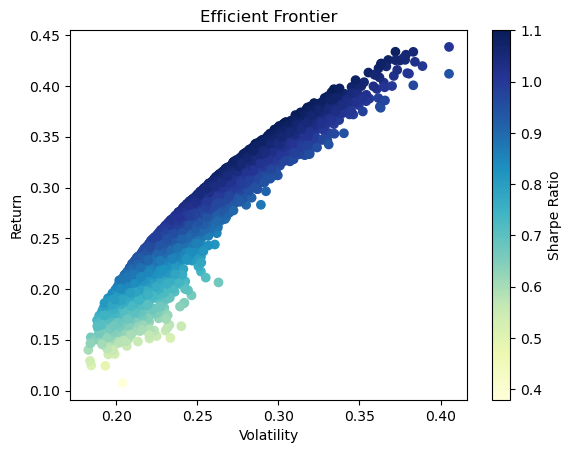

In [94]:
# Create a scatter plot of the efficient frontier

# The x-axis represents volatility, the y-axis represents return, and the color represents the Sharpe ratio
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')  # Scatter plot with color based on Sharpe ratio

# Set the title of the plot
plt.title('Efficient Frontier')

# Label the x-axis as 'Volatility'
plt.xlabel('Volatility')

# Label the y-axis as 'Return'
plt.ylabel('Return')

# Add a color bar to the plot to show the range of Sharpe ratios
plt.colorbar(label='Sharpe Ratio')

# Display the plot
plt.show()
